<a href="https://colab.research.google.com/github/toby-j/COM3029-NLP/blob/main/Spell_Checking_(Ex_1)_Toby_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Loading

In [1]:
try:
  !pip install datasets
  !pip install transformers
  !pip install language-tool-python
  !pip install contractions
  !apt-get install libhunspell-dev
  !pip install hunspell
except:
  import locale
  locale.getpreferredencoding = lambda: "UTF-8"
  !pip install datasets
  !pip install transformers
  !pip install language-tool-python
  !pip install contractions
  !apt-get install libhunspell-dev
  !pip install hunspell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 15.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.2 MB/s eta 0:00

In [2]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from numpy import *
import numpy as np

# Spelling imports
import hunspell
import re
import spacy
import language_tool_python
import spacy
import contractions

from collections import defaultdict

# Huggingface
from transformers import TFBertForSequenceClassification, AutoTokenizer
from datasets import Dataset, load_dataset, concatenate_datasets, DatasetDict

#Metrics
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Classnames

In [3]:
raw_dataset = load_dataset("go_emotions")

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

all_class_names = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

# Global Functions

## Display

In [5]:
def plot_graphs(vals, name, y_lim = 99999, y_scale = "linear", legend = []):
  """
  vals : list[list]
    a list of (a list of values for each epoch) - default expects [train values, test values]
  name : str
    name of type of values (goes on y-axis) eg "loss", "accuracy"
  y_lim : int
    greatest value on y axis is min(y_lim, max value in vals)
  y_scale : str
    controls scale of y-axis eg "linear", "logarithmic
  legend : list[str]
    allows for a custom legend
  """
  for val in vals:
    plt.plot(val)

  plt.ylabel(name)
  plt.xlabel("epoch")
  plt.xlim(0, len(vals[0]) - 1)
  if y_scale == "linear":
    plt.ylim(min(0, array(vals).min()), min(y_lim, array(vals).max()))
  plt.yscale(y_scale)

  if len(legend) > 0:
    plt.legend(legend)
  else:
    plt.legend(["train", "test"])

  plt.show()

  print(['{:.2e}'.format(v[-1]) for v in vals])

In [6]:
def output_metrics(model, test_data, test_labels):
  predictions = model.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
  print(f'F1 score: {f1_score(y_test, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(y_test, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(y_test, y_pred, average="weighted")}')

In [7]:
# Plot low, med, high spelling corrections based on Levenshtein distance
def plot_corrections(corrections):
    labels = list(corrections.keys())
    values = [len(corrections[label]) for label in labels]
    plt.bar(labels, values)
    plt.xlabel('Edit Distance Category')
    plt.ylabel('Number of Corrections')
    plt.title('Correction Counts by Edit Distance Category')
    plt.show()

In [8]:
def plot_confusion_matrix(model_input, test_data, test_labels):
  predictions = model_input.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  labels = list(set(y_test) | set(y_pred))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)
  
  plt.show()

## Utility

Functions shared across all experiments.

In [9]:
def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    tokenizer_out = tokenizer(data["text"], padding = "max_length", truncation = True, max_length = seq_len) # Sets length of tokenized string to mean token sequence length
    for key in tokenizer_out:
      data[key] = tokenizer_out[key]
    return data

## Variables
Variables that are shared across all experiments.

In [10]:
#Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

## Levenshtein Distance Algorithm
This algorithm measures how different two words are. This based on the number of characters needed to be altered.

To visualise how the changes of each experiment are different from each other, I use this algorithm to calculate low, medium and high edit distances of words that Hunspell corrects.

The more low edit distances that are made, the more likely the correction that Hunspell made was indeed correct. Therefore, we're looking at minimising medium and high edit distances.

In [11]:
def levenshtein_distance(s, t):
    # Normalise lengths
    m, n = len(s), len(t)
    if m < n:
        # if length of t is greater s, swap them round.
        return levenshtein_distance(t, s)
    if n == 0:
        return m
    previous_row = range(n + 1)
    for i, c1 in enumerate(s):
        current_row = [i + 1]
        for j, c2 in enumerate(t):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

# Introduction

This notebook is a pre-processing experiment, which introduces spell-checking on a standardised control model trained on the GoEmotions dataset. As as group we developed the control model to ensure an accurate and trustworthy comparson of results from each of our experiments.

## Control Model

We've used the same control model throughout the group, to allow for accurate comparson of results. The control model has the following setup:

*   14 chosen classes. Samples outside of the 14 classes are removed.
*   Simple tokenisation.
*   The ADAM activation function has been been utilised as the optimizer.
*   A Transformer based model that utilises transfer learning based on the BERT transformer model with the addition of a TF Dense layer with the sigmoid activiation function which enables multi class prediction.

# Control

## Dataset Preparation
The following section describes the standardised way in which the dataset is prepared for training. These steps include the filtering of classes to ensure the dataset only includes the required 14. The prepartaion of the dataset has been controlled (kept the same) for each experiment to enable accurate and fair measuring of the results yielded by the modified variable in each experiment.

{'grief': 77, 'pride': 111, 'relief': 153, 'nervousness': 164, 'embarrassment': 303, 'remorse': 545, 'fear': 596, 'desire': 641, 'disgust': 793, 'excitement': 853, 'surprise': 1060, 'caring': 1087, 'realization': 1110, 'disappointment': 1269, 'sadness': 1326, 'confusion': 1368, 'joy': 1452, 'anger': 1567, 'optimism': 1581, 'disapproval': 2022, 'love': 2086, 'curiosity': 2191, 'amusement': 2328, 'annoyance': 2470, 'gratitude': 2662, 'approval': 2939, 'admiration': 4130, 'neutral': 14219}


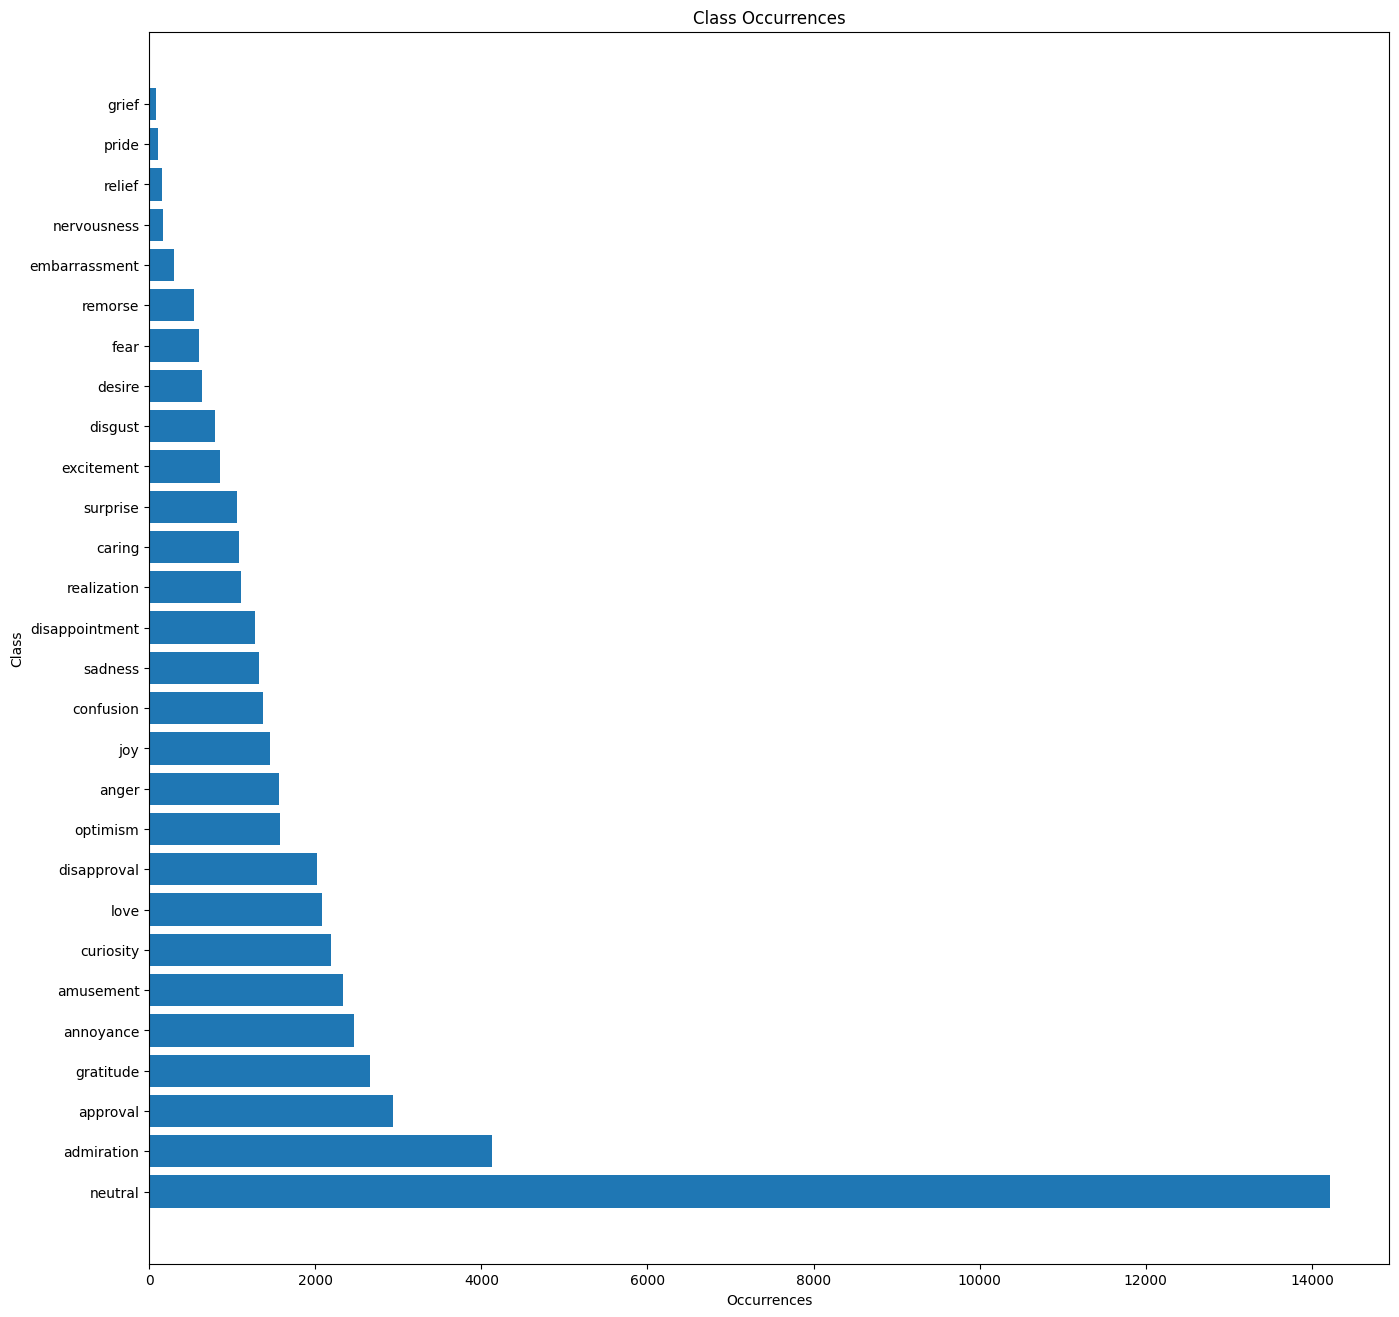

In [12]:
def count_classes(class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for item in raw_dataset['train']:
      for class_name in item['labels']:
            class_counts[all_class_names[class_name]] += 1
    return class_counts

feature_distribution = dict(sorted(count_classes(all_class_names).items(), key=lambda item: item[1])) 

print(feature_distribution)

def plot_class_occurrences(class_counts):
    # Get the class names and occurrence counts
    class_names = list(class_counts.keys())
    class_counts = list(class_counts.values())

    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.barh(class_names, class_counts)

    # Set the axis labels and title
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Class')
    ax.set_title('Class Occurrences')

    # Invert the y-axis to show the classes in descending order of occurrences
    ax.invert_yaxis()

    # Show the plot
    plt.show()

plot_class_occurrences(feature_distribution)

In [13]:
# Get top 14 most frequently occuring keys in dataset and fetch their indices
class_names = list(feature_distribution.keys())[-14:]
class_name_idxs = [all_class_names.index(x) for x in class_names]
print(list(zip(class_names, class_name_idxs)))

[('sadness', 25), ('confusion', 6), ('joy', 17), ('anger', 2), ('optimism', 20), ('disapproval', 10), ('love', 18), ('curiosity', 7), ('amusement', 1), ('annoyance', 3), ('gratitude', 15), ('approval', 4), ('admiration', 0), ('neutral', 27)]


In [14]:
# Here's the indexs of our selected classes
print(class_name_idxs)

[25, 6, 17, 2, 20, 10, 18, 7, 1, 3, 15, 4, 0, 27]


## Filtering

We'll now filter the dataset so it only contains the classes we're interested in

In [15]:
def flatten_list(arr):
  return [num for sublist in arr for num in sublist]

In [16]:
# If it has at least one label that is the selected subset of classes it's valid
def is_valid(data_item):
  return not (len(data_item["labels"]) == 1 and data_item["labels"][0] not in class_name_idxs)

# Remove classes that don't have a label in our 14 selected classes 
def remove_invalid_classes(data_item):
  data_item["labels"] = [label for label in data_item["labels"] if label in class_name_idxs] 

  for label in data_item["labels"]:
    assert label in class_name_idxs

  data_item["labels"] = [class_name_idxs.index(label) for label in data_item["labels"]][0:1] # "Rename" old labels

  return data_item

def one_hot_labels(data_item):
  data_item["labels"] = sum(to_categorical(data_item["labels"], len(class_name_idxs)), axis = 0)
  return data_item

# Apply dataset processing
dataset = raw_dataset.filter(lambda x: is_valid(x)).map(remove_invalid_classes)

# One-hot the labels
dataset_control = dataset.map(one_hot_labels)

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

## Tokenisation

In [ ]:
seq_lens = [len(tokenizer(x)["input_ids"]) for x in dataset_control["train"]["text"]]

seq_len = int(ceil(mean(seq_lens) + std(seq_lens)))

dataset_tokenized = dataset_control.map(tokenize_dataset)

print(dataset_tokenized)

## Model Definition
In this experiment. We are not changing the model, so both utilise this definition.

In [ ]:
# Resets TF graph to release memory
tf.keras.backend.clear_session()

def define_model():
  input_ids = Input(shape = (seq_len,), dtype = "int32", name = "input_ids")
  token_type_ids = Input(shape = (seq_len,), dtype = "int32", name = "token_type_ids")
  attention_masks = Input(shape = (seq_len,), dtype = "int32", name = "attention_mask")

  bert = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 14)

  inputs = {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids}
  outputs = bert(inputs)
  model = outputs.logits
  
  model = Dense(14, activation = "softmax")(model)

  model = Model(inputs = [input_ids, token_type_ids, attention_masks], outputs = model)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

define_model().summary()

model = define_model()

early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 8, restore_best_weights = True)

In [ ]:
model = define_model()

batch_size = 128

def create_test_dataset(ds):
  return ds["train"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)
  
def create_train_dataset(ds):
  return ds["test"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)

## Control Training

In [ ]:
control_tf_test_dataset = create_test_dataset(dataset_tokenized)
control_tf_train_dataset = create_train_dataset(dataset_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
control_test_display_item = list(control_tf_test_dataset)[1]
control_test_data, control_test_labels = control_test_display_item

control_history = model.fit(control_tf_train_dataset, validation_data = control_tf_test_dataset , epochs = 40, callbacks = [early_stopping]).history

## Metrics

In [ ]:
output_metrics(model, control_test_data, control_test_labels)
plot_confusion_matrix(model, control_test_data, control_test_labels)

# Experiment 1.0: Spell-check
---
Here I define the function that spell checks the training dataset. I picked the Hunspell library as it's well estbalished and used in large commercial applications such as Firefox.

If we give Hunspell a word, and it isn't in Hunspell's dictionary, it will give us a suggestion. I replace the word with this suggestion. Hunspell does not consider context.

With `hobj.spell(word)`:

> If `False`, we then ask Hunspell to give us a correction of the word. If it's able to return a correction of the word, we add it to an array of valid words.

> If it's `True`, we add this word to the array of valid words.

Once we've processed each word, the array of valid words will hold our corrected sentence. We then return this array as a string.

As we're using:

> `dataset_spell_checking['train'].map(correct_spelling)`

This string of our new valid sentence replaces the sentence in `['train']`. Using map() we repeat this process for every sentence in `dataset['train']`.

## Preparation

In [ ]:
# We take a copy of the dataset that we processed earlier before tokenisation is applied.
dataset_1 = dataset_control.copy()
print(dataset_1)

In [ ]:
# Load the Hunspell dictionary and affix file
hobj = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

# Create a dictionary to store corrections
corrections_1 = {
    "Low Edit Distance": [],
    "Medium Edit Distance": [],
    "High Edit Distance": []
} 

## Spell-checking

In [ ]:
# Define a function to correct misspelled words in a sentence
def correct_spelling(example):
    # Remove punctuation
    # sentence = re.sub(r'[^\w\s]', '', example['text'])
    words = example['text'].split()
    for j, word in enumerate(words):
        if not hobj.spell(word):
            # If word is misspelled, suggest corrections
            suggestions = hobj.suggest(word)
            if suggestions:
                # Replace misspelled word with first suggestion
                words[j] = suggestions[0]
                # Categorize correction based on edit distance
                distance = levenshtein_distance(word, suggestions[0])
                if distance <= 1:
                    corrections_1['Low Edit Distance'].append((word, suggestions[0]))
                elif distance <= 3:
                    corrections_1['Medium Edit Distance'].append((word, suggestions[0]))
                else:
                    corrections_1['High Edit Distance'].append((word, suggestions[0]))
    # Join the words back into a sentence and replace the original sentence in the dataset
    example['text'] = ' '.join(words)
    return example

In [ ]:
# Apply the correction function to the entire dataset using map
# This returns a dict. So we need to wrap the dict containing 3 datsets into a single dataset again
train_corrected = dataset_1['train'].map(correct_spelling)

In [ ]:
dataset_1['train'] = train_corrected

In [ ]:
dataset_1 = DatasetDict(dataset_1)

## Initial Evaluation

In [ ]:
# Call the function to plot the corrections
plot_corrections(corrections_1)
print("Low Edit Distance count: {}".format(len(corrections_1['Low Edit Distance'])))
print("Medium Edit Distance count: {}".format(len(corrections_1['Medium Edit Distance'])))
print("High Edit Distance count: {}".format(len(corrections_1['High Edit Distance'])))

## Tokenization

In [ ]:
experiment_1_tokenized = dataset_1.map(tokenize_dataset)

## Training

In [ ]:
experiment_1_tf_test_dataset = create_test_dataset(experiment_1_tokenized)
experiment_1_tf_train_dataset = create_train_dataset(experiment_1_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_1_test_display_item = list(experiment_1_tf_test_dataset)[1]
experiment_1_test_data, experiment_1_test_labels = experiment_1_test_display_item

experiment_1_history = model.fit(experiment_1_tf_train_dataset, validation_data = experiment_1_tf_test_dataset , epochs = 40, callbacks = [early_stopping]).history

## Metrics

In [ ]:
output_metrics(model, experiment_1_test_data, experiment_1_test_labels)
plot_confusion_matrix(model, experiment_1_test_data, experiment_1_test_labels)

# Experiment 1.1: Expanding contractions before spell-checking
Next I'll expand contracted words, for example "don't" and "they're" into their expanded form. My justification for this is all expanded and contracted words will now have the same token. Instead of being treated as seperate tokens as they will be a mix of contracted and expanded forms.

This will reduce the vocabulary size, which could improve the performance of our model. Therefore, I believe it's a worthwhile experiment.

## Preparation

In [ ]:
import language_tool_python
import spacy
import contractions

In [ ]:
# Make another copy to use for 1.1
dataset_1_1 = dataset_control.copy()

In [ ]:
corrections_1_1 = {
    "Low Edit Distance": [],
    "Medium Edit Distance": [],
    "High Edit Distance": []
} 

## Contracting before spell-checking function

In [ ]:
# Define a function to correct misspelled words in a sentence
def contract_before_spell_correct(example):
    sentence = []
    for word in example['text'].split():
      sentence.append(contractions.fix(word))
    words = ' '.join(sentence).split()
    for j, word in enumerate(words):
        if not hobj.spell(word):
            # If word is misspelled, suggest corrections
          suggestions = hobj.suggest(word)
          if suggestions:
              # Replace misspelled word with first suggestion
              words[j] = suggestions[0]
              distance = levenshtein_distance(word, suggestions[0])
              if distance <= 1:
                  corrections_1_1['Low Edit Distance'].append((word, suggestions[0]))
              elif distance <= 3:
                  corrections_1_1['Medium Edit Distance'].append((word, suggestions[0]))
              else:
                  corrections_1_1['High Edit Distance'].append((word, suggestions[0]))
    # Join the words back into a sentence and replace the original sentence in the dataset
    example['text'] = ' '.join(words)
    return example

In [ ]:
train_corrected = dataset_1_1['train'].map(contract_before_spell_correct)

In [ ]:
dataset_1_1['train'] = train_corrected

In [ ]:
for i in range(100):
  print(dataset_1_1['train']['text'][i])

In [ ]:
dataset_1_1 = DatasetDict(dataset_1_1)

## Initial Evaluation

In [ ]:
# Call the function to plot the corrections
print("Low Edit Distance count: {}".format(len(corrections_1_1['Low Edit Distance'])))
print("Medium Edit Distance count: {}".format(len(corrections_1_1['Medium Edit Distance'])))
print("High Edit Distance count: {}".format(len(corrections_1_1['High Edit Distance'])))
plot_corrections(corrections_1_1)

## Tokenization

In [ ]:
experiment_1_1_tokenized = dataset_1_1.map(tokenize_dataset)

## Training

In [ ]:
experiment_1_1_tf_test_dataset = create_test_dataset(experiment_1_1_tokenized)
experiment_1_1_tf_train_dataset = create_train_dataset(experiment_1_1_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_1_1_test_display_item = list(experiment_1_1_tf_test_dataset)[1]
experiment_1_1_test_data, experiment_1_1_test_labels = experiment_1_1_test_display_item

experiment_1_1_history = model.fit(create_train_dataset(experiment_1_1_tokenized), validation_data = create_test_dataset(experiment_1_1_tokenized), epochs = 40, callbacks = [early_stopping]).history

## Metrics

In [ ]:
output_metrics(model, experiment_1_1_test_data, experiment_1_1_test_labels)
plot_confusion_matrix(model, experiment_1_1_test_data, experiment_1_1_test_labels)

# Experiment 1.2: Adding part-of-speach (POS) tagging
---
Upon analysing the results of the spell checker. I looked into ways to improve the results further. Looking into the processed dataset, I noticed various false postive corrections. 

The pre-trained model I'm using from spacy will access the word's grammatical role in the sentence.

If the words are tagged as: `["NOUN", "VERB", "ADJ", "ADV"]` then we spell check the words. My reasoning for this is because misspelled words that are not in these categories will be difficult to spellcheck correclty. We should be able to see a drop in high distance corrections.

Looking into this dataset some more, it contains various slang and abrivations which won't be recognised in Hunspell's dictionary and Hunspell will correct them. This could decrease our accuracy as while they're not in a dictionary, they're used in other sentences accross the dataset with the same spelling.

The function will now not run the Hunspell spell-checker on words that aren't in the category of: `["NOUN", "VERB", "ADJ", "ADV"]`. So these slang and abrivations terms won't be passed into the spell-checker.







## Preparation

In [ ]:
# Make another copy to use for 1.1
dataset_1_2 = dataset_control.copy()

In [ ]:
corrections_1_2 = {
    "Low Edit Distance": [],
    "Medium Edit Distance": [],
    "High Edit Distance": []
} 

## Correct spelling after POS check

In [ ]:
# Load the pre-trained spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define a function to correct misspelled words and perform POS tagging in a sentence
def correct_spelling_with_pos(example):
    sentence = []
    for word in example['text'].split():
      sentence.append(contractions.fix(word))
    expanded_text = ' '.join(sentence)
    doc = nlp(expanded_text)
    words = []
    for token in doc:
        # Check if word is a noun, verb, adjective, or adverb
          if token.pos_ in ["NOUN", "VERB", "ADJ", "ADV"]:
            # If word is not spelled correctly, suggest corrections
            if not hobj.spell(token.text):
                suggestions = hobj.suggest(token.text)
                if suggestions:
                    # Replace misspelled word with first suggestion
                    words.append(suggestions[0])
                    distance = levenshtein_distance(word, suggestions[0])
                    if distance <= 1:
                        corrections_1_2['Low Edit Distance'].append((word, suggestions[0]))
                    elif distance <= 3:
                        corrections_1_2['Medium Edit Distance'].append((word, suggestions[0]))
                    else:
                        corrections_1_2['High Edit Distance'].append((word, suggestions[0]))
                else:
                    # If no suggestions are available, keep original word
                    words.append(token.text)
            else:
                # If word is spelled correctly, keep original word
                words.append(token.text)
          # If word is not a noun, verb, adjective, or adverb, ignore spell-checking. Keep the original word.
          else:
            words.append(token.text)
    # Join the words back into a sentence and replace the original sentence in the dataset
    example['text'] = ' '.join(words)
    return example

In [ ]:
train_corrected = dataset_1_2['train'].map(correct_spelling_with_pos)

In [ ]:
dataset_1_2['train'] = train_corrected

In [ ]:
dataset_1_2 = DatasetDict(dataset_1_2)

## Tokenization

In [ ]:
experiment_1_2_tokenized = dataset_1_2.map(tokenize_dataset)

## Initial Evaluation

In [ ]:
# Call the function to plot the corrections
print("Low Edit Distance count: {}".format(len(corrections_1_2['Low Edit Distance'])))
print("Medium Edit Distance count: {}".format(len(corrections_1_2['Medium Edit Distance'])))
print("High Edit Distance count: {}".format(len(corrections_1_2['High Edit Distance'])))
plot_corrections(corrections_1_2)

## Training

In [ ]:
experiment_1_2_tf_test_dataset = create_test_dataset(experiment_1_2_tokenized)
experiment_1_2_tf_train_dataset = create_train_dataset(experiment_1_2_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_1_2_test_display_item = list(experiment_1_2_tf_test_dataset)[1]
experiment_1_2_test_data, experiment_1_2_test_labels = experiment_1_2_test_display_item

experiment_1_2_history = model.fit(create_train_dataset(experiment_1_2_tokenized), validation_data = create_test_dataset(experiment_1_2_tokenized), epochs = 40, callbacks = [early_stopping]).history

## Metrics

In [ ]:
output_metrics(model, experiment_1_2_test_data, experiment_1_2_test_labels)
plot_confusion_matrix(model, experiment_1_2_test_data, experiment_1_2_test_labels)

# Experiment 1.3: Removing punctuation before spell-checking

## Preparation

In [ ]:
dataset_1_3 = dataset_control.copy()

In [ ]:
corrections_1_3 = {
    "Low Edit Distance": [],
    "Medium Edit Distance": [],
    "High Edit Distance": []
} 

## Remove punctuation then correct spelling

In [ ]:
# Define a function to correct misspelled words in a sentence
def correct_spelling_remove_punctuation(example):
    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', '', example['text'])
    words = sentence.split()
    for j, word in enumerate(words):
        if not hobj.spell(word):
            # If word is misspelled, suggest corrections
            suggestions = hobj.suggest(word)
            if suggestions:
                # Replace misspelled word with first suggestion
                words[j] = suggestions[0]
                # Categorize correction based on edit distance
                distance = levenshtein_distance(word, suggestions[0])
                if distance <= 1:
                    corrections_1_3['Low Edit Distance'].append((word, suggestions[0]))
                elif distance <= 3:
                    corrections_1_3['Medium Edit Distance'].append((word, suggestions[0]))
                else:
                    corrections_1_3['High Edit Distance'].append((word, suggestions[0]))
    # Join the words back into a sentence and replace the original sentence in the dataset
    example['text'] = ' '.join(words)
    return example

In [ ]:
train_corrected = dataset_1_3['train'].map(correct_spelling_remove_punctuation)

In [ ]:
dataset_1_3['train'] = train_corrected

In [ ]:
dataset_1_3 = DatasetDict(dataset_1_3)

## Tokenization

In [ ]:
experiment_1_3_tokenized = dataset_1_3.map(tokenize_dataset)

## Initial Evaluation

In [ ]:
# Call the function to plot the corrections
print("Low Edit Distance count: {}".format(len(corrections_1_3['Low Edit Distance'])))
print("Medium Edit Distance count: {}".format(len(corrections_1_3['Medium Edit Distance'])))
print("High Edit Distance count: {}".format(len(corrections_1_3['High Edit Distance'])))
plot_corrections(corrections_1_3)

## Training

In [ ]:
experiment_1_3_tf_test_dataset = create_test_dataset(experiment_1_3_tokenized)
experiment_1_3_tf_train_dataset = create_train_dataset(experiment_1_3_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_1_3_test_display_item = list(experiment_1_3_tf_test_dataset)[1]
experiment_1_3_test_data, experiment_1_3_test_labels = experiment_1_3_test_display_item

experiment_1_3_history = model.fit(create_train_dataset(experiment_1_3_tokenized), validation_data = create_test_dataset(experiment_1_3_tokenized), epochs = 40, callbacks = [early_stopping]).history

## Metrics

In [ ]:
output_metrics(model, experiment_1_3_test_data, experiment_1_3_test_labels)
plot_confusion_matrix(model, experiment_1_3_test_data, experiment_1_3_test_labels)

# Evaulation

## Loss

In [ ]:
import numpy as np

control_loss = np.array(control_history["loss"])
experiment_1_loss = np.array(experiment_1_history["loss"])
experiment_1_1_loss = np.array(experiment_1_1_history["loss"])
experiment_1_2_loss = np.array(experiment_1_2_history["loss"])
experiment_1_3_loss = np.array(experiment_1_3_history["loss"])

max_length = max(len(control_loss), len(experiment_1_loss), len(experiment_1_1_loss), len(experiment_1_2_loss), len(experiment_1_3_loss))

control_loss_padded = np.pad(control_loss, (0, max_length - len(control_loss)), mode='constant')
experiment_1_loss_padded = np.pad(experiment_1_loss, (0, max_length - len(experiment_1_loss)), mode='constant')
experiment_1_1_loss_padded = np.pad(experiment_1_1_loss, (0, max_length - len(experiment_1_1_loss)), mode='constant')
experiment_1_2_loss_padded = np.pad(experiment_1_2_loss, (0, max_length - len(experiment_1_2_loss)), mode='constant')
experiment_1_3_loss_padded = np.pad(experiment_1_3_loss, (0, max_length - len(experiment_1_3_loss)), mode='constant')

plot_graphs([control_loss_padded, experiment_1_loss_padded, experiment_1_1_loss_padded, experiment_1_2_loss_padded, experiment_1_3_loss_padded], name="Loss", legend=["Control", "Spell-check", "Expanding contractions before spell-checking", "POS Tagging", "Removing punctuation before spell-checking"])


### No Control

In [ ]:
plot_graphs([experiment_1_loss_padded, experiment_1_1_loss_padded, experiment_1_2_loss_padded, experiment_1_3_loss_padded], name="Loss", legend=["Spell-check", "Expanding contractions before spell-checking", "POS Tagging", "Removing punctuation before spell-checking"])


## Validation Loss

In [ ]:
import numpy as np

control_val_loss = np.array(control_history["val_loss"])
experiment_1_val_loss = np.array(experiment_1_history["val_loss"])
experiment_1_1_val_loss = np.array(experiment_1_1_history["val_loss"])
experiment_1_2_val_loss = np.array(experiment_1_2_history["val_loss"])
experiment_1_3_val_loss = np.array(experiment_1_3_history["val_loss"])

max_length = max(len(control_val_loss), len(experiment_1_val_loss), len(experiment_1_1_val_loss), len(experiment_1_2_val_loss), len(experiment_1_3_val_loss))

control_val_loss_padded = np.pad(control_val_loss, (0, max_length - len(control_val_loss)), mode='constant')
experiment_1_val_loss_padded = np.pad(experiment_1_val_loss, (0, max_length - len(experiment_1_val_loss)), mode='constant')
experiment_1_1_val_loss_padded = np.pad(experiment_1_1_val_loss, (0, max_length - len(experiment_1_1_val_loss)), mode='constant')
experiment_1_2_val_loss_padded = np.pad(experiment_1_2_val_loss, (0, max_length - len(experiment_1_2_val_loss)), mode='constant')
experiment_1_3_val_loss_padded = np.pad(experiment_1_3_val_loss, (0, max_length - len(experiment_1_3_val_loss)), mode='constant')

plot_graphs([control_val_loss_padded, experiment_1_val_loss_padded, experiment_1_1_val_loss_padded, experiment_1_2_val_loss_padded, experiment_1_3_val_loss_padded], name="val_loss", legend=["Control", "Spell-check", "Expanding contractions before spell-checking", "POS Tagging", "Removing punctuation before spell-checking"])


### No Control

In [ ]:
plot_graphs([experiment_1_val_loss_padded, experiment_1_1_val_loss_padded, experiment_1_2_val_loss_padded, experiment_1_3_val_loss_padded], name="val_loss", legend=["Spell-check", "Expanding contractions before spell-checking", "POS Tagging", "Removing punctuation before spell-checking"])

## Accuracy

In [ ]:
import numpy as np

control_accuracy = np.array(control_history["accuracy"])
experiment_1_accuracy = np.array(experiment_1_history["accuracy"])
experiment_1_1_accuracy = np.array(experiment_1_1_history["accuracy"])
experiment_1_2_accuracy = np.array(experiment_1_2_history["accuracy"])
experiment_1_3_accuracy = np.array(experiment_1_3_history["accuracy"])

max_length = max(len(control_accuracy), len(experiment_1_accuracy), len(experiment_1_1_accuracy), len(experiment_1_2_accuracy), len(experiment_1_3_accuracy))

control_accuracy_padded = np.pad(control_accuracy, (0, max_length - len(control_accuracy)), mode='constant')
experiment_1_accuracy_padded = np.pad(experiment_1_accuracy, (0, max_length - len(experiment_1_accuracy)), mode='constant')
experiment_1_1_accuracy_padded = np.pad(experiment_1_1_accuracy, (0, max_length - len(experiment_1_1_accuracy)), mode='constant')
experiment_1_2_accuracy_padded = np.pad(experiment_1_2_accuracy, (0, max_length - len(experiment_1_2_accuracy)), mode='constant')
experiment_1_3_accuracy_padded = np.pad(experiment_1_3_accuracy, (0, max_length - len(experiment_1_3_accuracy)), mode='constant')

plot_graphs([control_accuracy_padded, experiment_1_accuracy_padded, experiment_1_1_accuracy_padded, experiment_1_2_accuracy_padded, experiment_1_3_accuracy_padded], name="accuracy", legend=["Control", "Spell-check", "Expanding contractions before spell-checking", "POS Tagging", "Removing punctuation before spell-checking"])


### No Control

In [ ]:
plot_graphs([experiment_1_accuracy_padded, experiment_1_1_accuracy_padded, experiment_1_2_accuracy_padded, experiment_1_3_accuracy_padded], name="accuracy", legend=["Spell-check", "Expanding contractions before spell-checking", "POS Tagging", "Removing punctuation before spell-checking"])

# Retired methods
---
Here I've documented methods that I explored but removed from the final experiment.

I wanted to access the effectiveness of POS tagging. My first approach was seeing if it could correct more sentences with spelling mistakes than without POS.

I loaded the COCO Captions dataset and took the first sentences of each set in the train set. This gave me 10000 correct sentences. I then developed a function that, with a 40% chance add a random charecter into the word.

A correct correction would be if the spell checking function could correct the sentences back to it's ground truth. However, I found that both functions struggled to restore every incorrect word of the sentence back to the ground-truth. I concluded that it would too difficult of a task for a both methods and that if even if I increased the testing data, the results wouldn't be conclusive.

I then decided to access the difference with a subset of GoEmotions and manually access the results, instead of trying to record measurements. I will then evaluate how the methods should perform given the entire dataset.

In [ ]:
# from tqdm import tqdm

# import random

# coco_captions_raw = load_dataset("embedding-data/coco_captions_quintets")
# # Flatten to just the first element
# correct_sentences = [item[0] for item in coco_captions_raw['train'][:10000]['set']]

# def add_spelling_errors(sentence):
#     words = sentence.split()
#     for j, word in enumerate(words):
#         # Randomly replace some characters in the word with other characters
#         if random.random() < 0.4:
#             # Choose a random character from the word and replace it with another random character
#             i = random.randint(0, len(word)-1)
#             new_char = chr(random.randint(97, 122))  # choose a random lowercase letter
#             words[j] = word[:i] + new_char + word[i+1:]
#     # Join the words back into a sentence
#     sentence_with_errors = ' '.join(words)
#     return sentence_with_errors

# # Create a new list of sentences with spelling mistakes
# incorrect_sentences = []
# for sentence_arr in tqdm(correct_sentences):
#     sentence = sentence_arr
#     sentence = re.sub(r'[^\w\s]', '', sentence)
#     # Apply random spelling errors to the sentence
#     incorrect_sentence = add_spelling_errors(sentence)
#     incorrect_sentences.append(incorrect_sentence)

# # Create the incorrect and correct datasets
# from datasets import DatasetDict, Dataset

# incorrect_ds = Dataset.from_dict({"text": incorrect_sentences})
# correct_ds = Dataset.from_dict({"text": correct_sentences})

# spell_checking_ds = DatasetDict({"correct": correct_ds, "incorrect": incorrect_ds})

# correct_count = 0
# total_count = len(spell_checking_ds['incorrect']['text'])

# for i in range(total_count):
#     incorrect_sentence = spell_checking_ds['incorrect'][i]
#     corrected_sentence = correct_spelling_test(incorrect_sentence)
#     print(corrected_sentence)
#     print("CORRECTED SENTENCE {}".format(corrected_sentence['text'][i]))
#     ground_truth = spell_checking_ds['correct']['text'][i]
#     print("GROUND TRUTH {}".format(ground_truth))
#     if corrected_sentence == ground_truth:
#         correct_count += 1
#     else:
#         print(f"Incorrect: {incorrect_sentence}")
#         print(f"Corrected: {corrected_sentence}")
#         print(f"Ground truth: {ground_truth}")
#         print("")

# accuracy = correct_count / total_count
# print(f"Accuracy: {accuracy}")

# spell_checking_with_pos_ds = DatasetDict({"correct": correct_ds, "incorrect": incorrect_ds})

# correct_count = 0
# total_count = len(spell_checking_with_pos_ds['incorrect']['text'])

# for i in range(total_count):
#     incorrect_sentence = spell_checking_ds['incorrect'][i]
#     corrected_sentence = correct_spelling(incorrect_sentence)
#     print("CORRECTED SENTENCE {}".format(corrected_sentence))
#     ground_truth = spell_checking_ds['correct']['text'][i]
#     if corrected_sentence == ground_truth:
#         correct_count += 1
#     else:
#         print(f"Incorrect: {incorrect_sentence}")
#         print(f"Corrected: {corrected_sentence}")
#         print(f"Ground truth: {ground_truth}")
#         print("")

# accuracy = correct_count / total_count
# print(f"Accuracy: {accuracy}")
